## Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a technique used for text summarization. It helps to distill the essential information from a large amount of text by identifying the underlying latent topics or concepts. LSA leverages linear algebra and statistical methods to analyze the relationships between documents and the terms they contain. By constructing a document-term matrix and applying Singular Value Decomposition (SVD), LSA reduces the dimensionality of the matrix while capturing the main topics. It then computes a similarity matrix to measure the similarity between sentences based on these latent topics. The sentences with the highest scores are considered the most important and are selected to form the summary. LSA summarization provides a way to condense the content of documents, enabling users to quickly grasp the key points without having to read the entire text.

In [193]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

import contractions
import string
import re
import math

import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import networkx as nx
from rouge import Rouge

from sklearn.feature_extraction.text import TfidfVectorizer

In [194]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

### Text preprocessing

#### Preprocessing steps:
<ol>
<li>convert all characters in the text to lowercase</li>

**Example**: if the input text is "Hello World", it will be converted to "hello world".

<li>Tokenize the article into sentences using sent_tokenize function from the NLTK library.</li>

**Example**: if the input text is "Hello! How are you? I hope you're doing well. Have a great day!", it will be tokenized into the list of sentences ['Hello!', 'How are you?', "I hope you're doing well.", 'Have a great day!']

For each of the sentences perform the following preprocessing steps :
<ol>
<li>Remove all punctuation marks from the text using the translate method and maketrans function from the string module.</li>

**Example**: if the input text is "Hello, World!", it will be converted to "Hello World".

<li>Remove any non-alphanumeric characters from the text using regular expressions. It replaces any character that is not a word character (\w) or whitespace character (\s) with an empty string.</li> 

**Example**: if the input text is "Hello @world!", it will be converted to "Hello World".

<li>Expand contracted words in the text using the contractions library.</li>

**Example**: if the input preprocessed text is "I'm happy", it will be expanded to "I am happy".

<li>Tokenize the preprocessed text into individual words using the word_tokenize function from the NLTK library.</li> 

**Example**: if the input text is "Hello World", it will be tokenized into the list of tokens: ['Hello', 'World'].

<li>Remove stop words from the list of tokens. Stop words are commonly occurring words (e.g., "the", "is", "and") that do not carry much meaning in the context of natural language processing tasks.</li>

**Example**: if the input tokens are ['Hello', 'World', 'this', 'is', 'a'], and the stop words list contains ['this', 'is', 'a'], the resulting tokens will be ['Hello', 'World'].

</ol>
</ol>

In [195]:
def preprocess_text(text):
    """
    Preprocesses the input text by performing several text cleaning steps.
    
    Args:
        text (str): The input text to be preprocessed.
        
    Returns:
        tuple: A tuple containing two elements:
            - preprocessed_sentences (list): A list of preprocessed sentences, where each sentence is tokenized.
            - sentences (list): A list of original sentences (not preprocessed).
    """
    # Convert the text to lowercase.
    text = text.lower()
    
    # Tokenize the text into sentences.
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    preprocessed_sentences = []
    
    for sentence in sentences:
        
        # Remove punctuation from each sentence.
        sentence = sentence.translate(str.maketrans("", "", string.punctuation))
        
        # Remove non-alphanumeric characters
        sentence = re.sub(r"[^\w\s]", "", sentence)
        
        # Expand contractions
        sentence = contractions.fix(sentence)
        
        # Tokenize the sentence into individual words
        tokens = word_tokenize(sentence)
        
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        
        preprocessed_sentences.append(tokens)
    
    return preprocessed_sentences, sentences

### Apply pre-processing steps and Tokenize sentences in an article

In [196]:
data_df['processed_article', 'sentence_tokens'] = data_df['article'].apply(preprocess_text)

In [197]:
data_df['processed_article'] = data_df['processed_article', 'sentence_tokens'].apply(lambda x:x[0])
data_df['sentence_tokens'] = data_df['processed_article', 'sentence_tokens'].apply(lambda x:x[1])

### Calculate number of sentences to retain

In [198]:
data_df['num_retain_sentence'] = data_df['processed_article'].apply(lambda x: math.ceil(len(x)/10))

### Calculate most important sentences to form a summary

- The function plays a key role in text summarization using the Latent Semantic Analysis algorithm. 
- It takes a list of sentences as input and constructs a similarity matrix. First, it converts each sentence into a numerical representation called a sentence vector. 
- Then, it applies the TF-IDF transformation to these vectors, which assigns weights to words based on their frequency and rarity across the document. This step helps capture the importance of words within each sentence. 
- Finally, it calculates the cosine similarity between all pairs of sentences using the TF-IDF vectors.

**Example**:
Let's consider three sentences:

"I love to play soccer."<br>
"Soccer is my favorite sport."<br>
"I enjoy watching soccer matches."<br>

- The first step is to convert each sentence into a numerical representation called a sentence vector

Sentence 1 vector: [1, 1, 0, 0, 1, 0]<br>
Sentence 2 vector: [1, 1, 1, 1, 0, 1]<br>
Sentence 3 vector: [1, 0, 1, 0, 1, 1]<br>

- Apply the TF-IDF transformation to the sentence vectors.

$$TF-IDF = \lgroup\frac {\text{Term Frequency}}  {\text{Total terms in sentence}}\rgroup * log\lgroup\frac{\text{Total sentences}} {\text{Number of sentences containing the word}}\rgroup$$


Sentence 1 TF-IDF vector: [0.25, 0.25, 0, 0, 0.405, 0]<br>
Sentence 2 TF-IDF vector: [0.25, 0.25, 0.405, 0.405, 0, 0.405]<br>
Sentence 3 TF-IDF vector: [0.25, 0, 0.405, 0, 0.405, 0.405]<br>


- Next, the function applies the Latent Semantic Analysis (LSA) algorithm to reduce the dimensionality of the TF-IDF matrix. LSA captures the underlying latent topics in the sentences, condensing the information while retaining the most important semantic meaning.
- The LSA transformation produces a new matrix called the LSA matrix, which represents the sentences in a lower-dimensional space where each component corresponds to a latent topic.

The dimensionality is reduced using Singular Value Decomposition

Given an input matrix X of shape (m, n), where m represents the number of rows (samples) and n represents the number of columns (features), the SVD decomposes X into three matrices: U, Σ, and V^T.

$$X = U * Σ * V^T$$

$U$: The left singular vectors matrix of shape (m, k), where k is the number of components.<br>
$Σ$: The diagonal singular values matrix of shape (k, k), where k is the number of components.<br>
$V^T$: The right singular vectors matrix of shape (k, n), where k is the number of components.<br>

- The function then calculates sentence scores by summing the values along each row of the LSA matrix. Higher scores indicate more important sentences based on the latent topics.
- The sentences are ranked based on their scores in descending order to identify the most crucial sentences for the summary.
- Finally, the function selects the top num_sentences sentences with the highest scores and combines them to form the summary.


**Continuing the example**:

let's assume number of sentences to retain is 2, so LSA will reduce the dimensionality to 2 components.

Sentence 1: [0.7, 0.2]<br>
Sentence 2: [0.5, 0.6]<br>
Sentence 3: [0.3, 0.7]<br>

- The sentence scores would be

Sentence 1 score: 0.9 (0.7 + 0.2)<br>
Sentence 2 score: 1.1 (0.5 + 0.6)<br>
Sentence 3 score: 1.0 (0.3 + 0.7)<br>

The top sentences would be Sentence 2 and Sentence 3.

Combine the selected sentences to form the summary.

**summary**: "Soccer is my favorite sport. I enjoy watching soccer matches."


In [199]:
def get_summary(row):
    
    sentences = row['processed_article']
    sentence_tokens = row['sentence_tokens']
    num_sentences=row['num_retain_sentence']
    
    sentence_vectors = []
    
    for sentence in sentences:
        sentence_vectors.append(' '.join(sentence))
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentence_vectors)

    lsa_model = TruncatedSVD(n_components=num_sentences)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
    
    sentence_scores = lsa_matrix.sum(axis=1)
    
    ranked_sentences = sorted(((sentence_scores[i], s) for i, s in enumerate(sentence_tokens)), reverse=True)
    
    sentence_array = [sentence[1] for sentence in ranked_sentences[:num_sentences]]
    
    return ''.join([''.join(sentence) for sentence in sentence_array])

#### Apply summarization


In [200]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

### Calculate ROGUE Scores

The **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) scores represent the evaluation metrics for summarization. ROUGE measures the similarity between the generated summary (system summary) and the reference summary (ground truth summary) in terms of overlapping n-grams.

The scores are reported as follows:

**ROUGE-1**: This metric focuses on the overlap of unigram (single word) sequences between the system summary and the reference summary. It measures the recall (r), precision (p), and F1 score (f) for unigrams.

**ROUGE-2**: This metric considers the overlap of bigram (two-word) sequences between the system summary and the reference summary. It measures the recall, precision, and F1 score for bigrams.

**ROUGE-L**: This metric calculates the longest common subsequence (LCS) between the system summary and the reference summary. It measures the recall, precision, and F1 score based on the LCS.


- **Precision**: Precision measures the accuracy or correctness of the generated summary. It is the ratio of the number of correctly identified relevant elements (such as words or n-grams) in the generated summary to the total number of identified elements. A higher precision indicates a lower rate of false positives.

- **Recall**: Recall measures the comprehensiveness or completeness of the generated summary. It is the ratio of the number of correctly identified relevant elements in the generated summary to the total number of relevant elements present in the reference summary. A higher recall indicates a lower rate of false negatives.

- **F1 score**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that considers both precision and recall. The F1 score is calculated using the formula: F1 = 2 * (precision * recall) / (precision + recall). It ranges from 0 to 1, where a higher F1 score indicates a better balance between precision and recall.

In [201]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

#### Calculate Average Recall, Precision, and F1 score for Rouge-1, Rouge-2 and Rouge-L

In [202]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.232067,0.065061,0.214053
precision,0.213830,0.058774,0.197423
f1-score,0.209918,0.057231,0.193622


#### Barplot for ROGUE scores

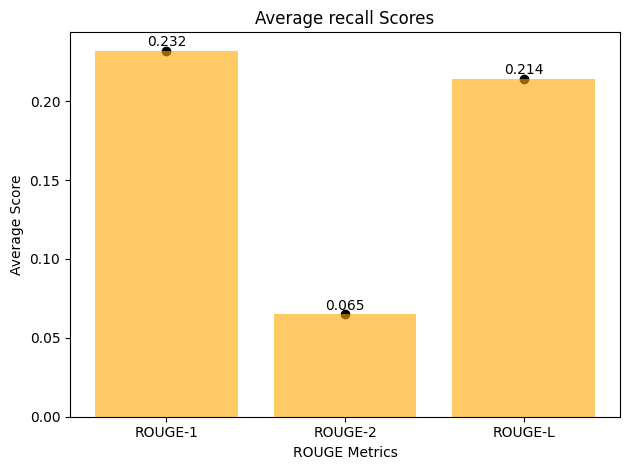

In [203]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

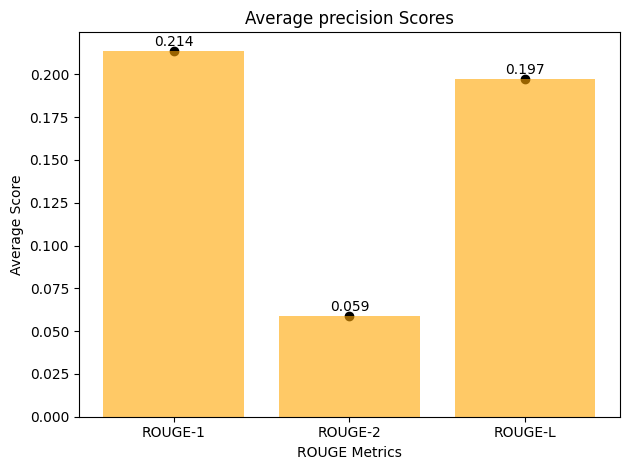

In [204]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

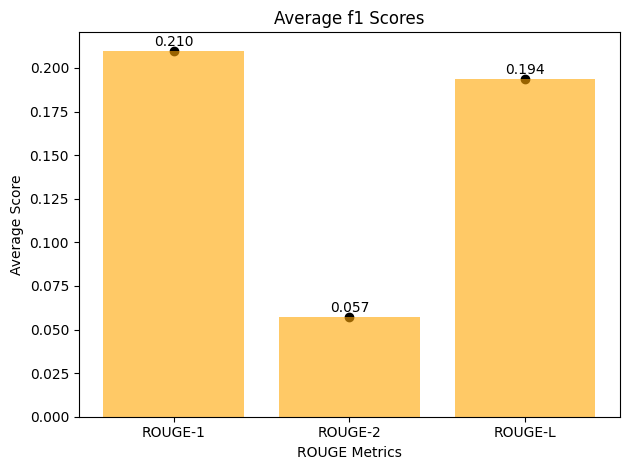

In [205]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

#### Plot Heatmap for ROGUE scores

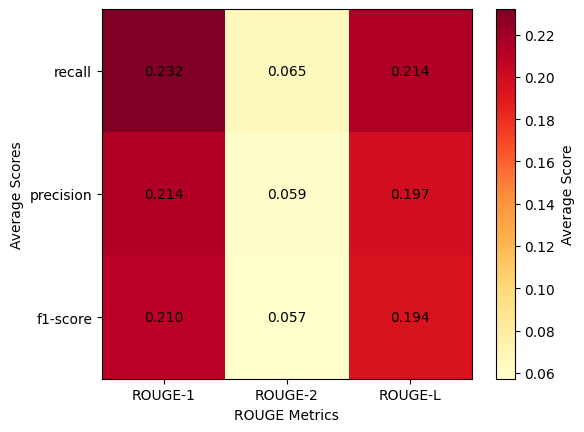

In [206]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()